## summary

In [1]:
import gc
import importlib.util
import sys
import time

import albumentations as albu
import torch.cuda.nccl
import wandb
import albumentations.pytorch
# import ToTensorV2
from torch.optim import lr_scheduler as LRS

sys.path.append("..")

import model.cv_metric as module_metric
import model.loss as module_loss
from logger.Loggers import *
from model.model import VesuviusModel as CustomModel
from utils import *
from utils.env_detect import *


/home/lz/mambaforge/envs/Ves/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/lz/mambaforge/envs/Ves/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


## Configs
### Env detection

In [2]:


Logger = get_logger(__name__)


### Auto settings

In [3]:


# ============== augmentation =============
def get_aug_list(size, in_channels, mode='train'):
    """
    type: train, valid
    return: list of albumentations

    in case of any further modification,
    one should use albu.Compose by themselves
    """

    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        albu.Resize(size, size),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomBrightnessContrast(p=0.75),
        albu.ShiftScaleRotate(p=0.75),
        albu.OneOf([
            albu.GaussNoise(var_limit=(10.0, 50.0)),
            albu.GaussianBlur(),
            albu.MotionBlur(),
        ], p=0.4),
        albu.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        albu.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3),
                           mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),

        albu.Normalize(
            mean=[0] * in_channels,
            std=[1] * in_channels,
            # max_pixel_value=1.0,
            always_apply=True,
        ),
        # pad is placed last
        # for not interfering with other aug,i.e.Normalize
        albu.PadIfNeeded(size, size,
                         position='top_left'),
        albu.pytorch.ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        albu.Resize(size, size),
        albu.Normalize(
            mean=[0] * in_channels,
            std=[1] * in_channels,
            # max_pixel_value=1.0,
            always_apply=True,
        ),
        albu.PadIfNeeded(size, size,
                         position='top_left'),
        albu.pytorch.ToTensorV2(transpose_mask=True),
    ]

    if mode == 'train':
        return train_aug_list
    else:
        return valid_aug_list


In [4]:

def get_config():
    HOST, PATHS = decide_paths()
    _cfg = yaml.safe_load(open(f"{PATHS['ROOT_DIR']}/dev/default_config.yaml", "r"))

    util.seed_everything(_cfg['seed'])

    PATHS = {k: str(v) for k, v in PATHS.items()}
    _cfg["PATHS"] = PATHS

    _cfg['dataset']['data_dir'] = PATHS['DATA_DIR']
    _cfg['dataset']['cache_dir'] = PATHS['CACHE_DIR']

    with open("config.yaml", "w") as f:
        yaml.dump(_cfg, f)

    # update in running cfgs
    device = torch.device("cuda" if torch.cuda.is_available()
                          else "mps" if torch.backends.mps.is_available() else "cpu")
    _cfg["device"] = device

    _cfg["kaggle_run_type"] = os.getenv("KAGGLE_KERNEL_RUN_TYPE")
    _cfg['HOST'] = HOST

    _cfg['data_loader']['num_workers'] = max(
        _cfg['data_loader']['num_workers'], os.cpu_count() - 2)
    # model id consist of settings of model,
    # exp_id add on the settings for dataset
    # run_id add on time
    cfg_model = _cfg['model']
    _cfg['model_id'] = f"{cfg_model['Proto']}_{cfg_model['in_channels']}_{cfg_model['model_type']}"

    _cfg['model_id'] += f"fold_( {'_'.join(_cfg['dataset']['image_sets'])} )"
    _cfg['exp_id'] = f"{_cfg['model_id']}_{cfg_model['tile_size']}"
    _cfg['run_id'] = f"{_cfg['exp_id']}_{time.strftime('%m%d_%H%M%S')}"

    if not os.path.exists(f"{PATHS['LOG_DIR']}/{_cfg['exp_id']}"):
        os.makedirs(f"{PATHS['LOG_DIR']}/{_cfg['exp_id']}")
    setup_logging(f"{PATHS['LOG_DIR']}/{_cfg['exp_id']}")

    import wandb
    Logger.info('wandb imported')

    t_resume = (_cfg['model']["resume"] is not None) and os.path.exists(
        get_saved_model_path(_cfg['PATHS']['CP_DIR'], _cfg['model_id']))
    t_mode = 'online' if _cfg["kaggle_run_type"] != "batch" and _cfg['wandb_mode'] == 'online' else 'offline'
    Logger.info(f'resuming: {t_resume}; wandb mode: {t_mode}')

    wandb.init(project=_cfg['comp_name'],
               name=_cfg['run_id'],
               config=_cfg,
               dir=_cfg['PATHS']['LOG_DIR'],
               resume=t_resume,
               tags=[
                   _cfg['model']['Proto'],
                   _cfg['model']['model_type'],
               ],
               notes='resumed',
               mode=t_mode)
    del t_resume, t_mode

    wandb.config['train_aug_list'] = albu.to_dict(albu.Compose(
        get_aug_list(cfg_model['tile_size'], cfg_model['in_channels'], mode='train')))
    wandb.config['valid_aug_list'] = albu.to_dict(albu.Compose(
        get_aug_list(cfg_model['tile_size'], cfg_model['in_channels'], mode='valid')))

    _cfg = wandb.config

    return _cfg

### Global cfg


In [5]:

g_cfg = get_config()
if g_cfg["device"] == "cpu":
    Logger.warning("No accelarater enabled, Start testing")
    testing = True
else:
    Logger.warning(f"accelarater: {g_cfg['device']}")
    testing = False

wandb imported
resuming: False; wandb mode: offline
Starting new HTTP connection (1): localhost:8888
http://localhost:8888 "GET /api/sessions?token=27ada6fdb0c9762a21775b46a7007a0031ca93153979a315 HTTP/1.1" 200 348
Popen(['git', 'cat-file', '--batch-check'], cwd=/home/lz/Codes/Vesuvius, universal_newlines=False, shell=None, istream=<valid stream>)


accelarater: cuda


### External models

In [6]:

if not g_cfg.kaggle_run_type == "batch":
    # https://github.com/Cadene/pretrained-models.pytorch/issues/222
    import ssl

    ssl._create_default_https_context = ssl._create_unverified_context

if g_cfg.HOST == 'kaggle':
    EXTERNAL_MODELS_DIR = Path(g_cfg.PATHS.EXTERNAL_MODELS_DIR)
    sys.path.append(str(EXTERNAL_MODELS_DIR / "segmentation-models-pytorch" / "segmentation_models.pytorch-master"))
    sys.path.append(str(EXTERNAL_MODELS_DIR / "pretrainedmodels" / "pretrainedmodels-0.7.4"))
    sys.path.append(str(EXTERNAL_MODELS_DIR / "efficientnet-pytorch" / "EfficientNet-PyTorch-master"))
    del EXTERNAL_MODELS_DIR

    # noinspection PyUnresolvedReferences
    import segmentation_models_pytorch as smp

else:
    if importlib.util.find_spec("segmentation_models_pytorch") is None:
        %pip install -y segmentation-models-pytorch
    # %%conda install -y -c conda-forge segmentation-models-pytorch

In [7]:
g_cfg["HOST"]

'Vincint'

## Helper functions

In [8]:
# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    # pixels = (pixels >= thr).astype(np.uint8)

    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# def np_rle(img):
#     flat_img = np.where(img.flatten() , 1, 0).astype(np.uint8)
#     starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
#     ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
#     starts_ix = np.where(starts)[0] + 2
#     ends_ix = np.where(ends)[0] + 2
#     lengths = ends_ix - starts_ix
#     predicted_arr = np.stack([starts_ix, lengths]).T.flatten()
#     rle_str=np.array2string(predicted_arr.reshape(-1), separator=' ')
#     return rle_str[1:-1]

## Model

In [9]:
# class CustomModel(nn.Module):
#     def __init__(self, cfg):
#         super().__init__()
#         self.cfg = cfg
#         self.th = None
#         # if cfg["model_name"] == "Unet++":
#         #     model_Conductor=getattr(smp, "UnetPlusPlus")
#         # else:
#         #     model_Conductor=getattr(smp, cfg["model_name"])
#         # self.encoder = model_Conductor(
#         self.encoder = getattr(smp, cfg["Proto"])(**cfg['args'])
#
#     def forward(self, image):
#         output = self.encoder(image)
#         # output = output.squeeze(-1)
#         return output


def build_model(cfg, cp_dir=g_cfg['PATHS']['CP_DIR'],
                model_id=g_cfg['model_id'], weight=None):
    """
    DO notice that this needs a global config
    for paths and model_id
    """
    Logger.info(f"model_cfg: {cfg}")
    if cfg['resume'] is not None:
        model_path = get_saved_model_path(cp_dir, model_id)
        if os.path.exists(model_path):
            Logger.info(f'load model from: {model_path}')
            _model = CustomModel(cfg)
            loaded_model = torch.load(model_path)
            # print(loaded_model)
            _model.load_state_dict(loaded_model['model'])
            # best_loss = loaded_model['best_loss']
            # best_loss = None if loaded_model['best_loss'] is None else loaded_model['best_loss']
            # best_loss = loaded_model['best_loss']
            th = loaded_model['th'] if 'th' in loaded_model else 0.5
            _model.th = th
            return _model
        Logger.info(f'trained model not found')

    # if cfg['HOST']=='kaggle':
    #     weight = None
    _model = CustomModel(cfg)
    _model.th = 0.5
    return _model

## DataSet

In [10]:



def get_transforms(mode, cfg):
    return albu.Compose(get_aug_list(cfg['tile_size'], cfg['in_channels'], mode=mode))


from data_loader import datasets, data_loaders


available memory size is 20.73944854736328 GB


In [11]:
def make_dataset(cfg, trfs_mode='train'):
    imgset_paths = [f"train/{i}" for i in cfg['image_sets']]
    imgs = []
    masks = []
    labels = []
    for path in imgset_paths:
        imgs.append(f"{path}/surface_volume")
        masks.append(f"{path}/mask.png")
        labels.append(f"{path}/inklabels.png")

    dataset = getattr(datasets, cfg['type'])(
        image_sets=imgs,
        cfg=cfg,
        masks=masks,
        labels=labels,
        transform=get_transforms(mode=trfs_mode, cfg=cfg))
    return dataset


def make_data_loader(cfg, dataset):
    loader = getattr(data_loaders, cfg['type'])(
        dataset,
        **cfg['args'],
        pin_memory=True,
        drop_last=False)

    return loader

In [12]:
# dataset=make_dataset(g_cfg['dataset'])
# train_loader=make_data_loader(g_cfg['data_loader'],dataset)
# valid_lodaer=train_loader.split_validation()

## optimizer and Scheduler

In [13]:
def get_optimizer(cfg, model):
    _optimizer = getattr(torch.optim, cfg['type'])(
        model, **cfg['args'])
    return _optimizer


def get_scheduler(cfg, optimizer):
    _scheduler = getattr(LRS, cfg['type'])(
        optimizer, **cfg['args'])
    return _scheduler


def scheduler_step(_scheduler):
    _scheduler.step()

In [14]:
# model,loss =build_model(g_cfg['model'],model_id=g_cfg['model_id'],cp_dir=g_cfg['PATHS']['CP_DIR'])
# optimizer=get_optimizer(g_cfg['optimizer'],model)
# scheduler=get_scheduler(g_cfg['scheduler'],optimizer)

## Assessments

## LOSS

In [15]:
testing = True

USE Trainer

In [16]:
if testing:
    importlib.reload(datasets)
    g_cfg['data_loader']['args']['num_workers'] = 0
    from trainer.VesuviusTrainer import VesuviusTrainer as Trainer

    # def main(config):
    """
    Take global config and train model
    """
    logger = get_logger('train')
    config = g_cfg
    # setup data_loader instances
    # trms=get_aug_list(config['model']['tile_size'],config['model']['in_channels'],'train')

    full_dataset = make_dataset(config['dataset'])
    data_loader = make_data_loader(config['data_loader'], full_dataset)

    # data_loader = config.init_obj('data_loader', module_data)

    valid_data_loader = data_loader.split_validation()

    # build model architecture, then print to console
    # model = config.init_obj('arch', module_arch)
    model = build_model(config['model'])
    # logger.info(model)

    # prepare for (multi-device) GPU training
    device, device_ids = prepare_device(config['n_gpu'])
    model = model.to(device)
    if len(device_ids) > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)

    # get function handles of loss and metrics
    # criterion = module_loss.config['loss'] which should be a function
    criterion = getattr(module_loss, config['loss'])
    # metrics is module_metric.__dict__[config['metrics']] which should be a list of functions
    metrics = [getattr(module_metric, met) for met in config['metrics']]

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())

    optimizer = get_optimizer(config['optimizer'], trainable_params)
    lr_scheduler = get_scheduler(config['scheduler'], optimizer)

    trainer = Trainer(model, criterion, metrics, optimizer,
                      config=config,
                      device=device,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      len_epoch=1000)


model_cfg: {'Proto': 'Unet', 'resume': None, 'pretrained': True, 'model_type': 'Multi', 'tile_size': 224, 'in_channels': 6, 'args': {'encoder_name': 'se_resnext50_32x4d', 'encoder_weights': 'imagenet', 'in_channels': 6, 'classes': 1, 'activation': None}}


In [17]:
# if testing:
#     trainer.train()
#     del trainer, model, optimizer, lr_scheduler, data_loader, valid_data_loader
#     gc.collect()
#     torch.cuda.empty_cache()



In [18]:
img,label = data_loader.dataset[1]

matplotlib data path: /home/lz/mambaforge/envs/Ves/lib/python3.7/site-packages/matplotlib/mpl-data
CONFIGDIR=/home/lz/.config/matplotlib
interactive is False
platform is linux
loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', '_collections_abc', 'posixpath', 'genericpath', 'os.path', '_sitebuiltins', '_distutils_hack', 'types', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.util', 'importlib.abc', 'importlib.machinery', 'contextlib', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_collections', 'functools', '_functools', 'mpl_toolkits', 'google', 'runpy', 'pkgutil', 'weakref', '_wea

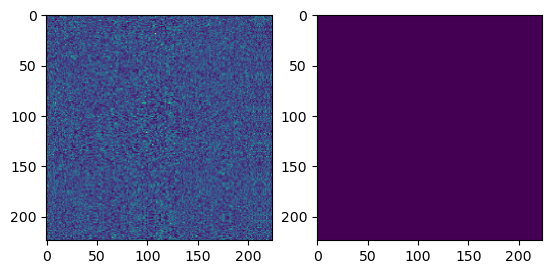

In [19]:
if testing:
    import matplotlib.pyplot as plt
    fig,axs=plt.subplots(1,2)
    axs[0].imshow(img.mean(0))
    axs[1].imshow(label)
    plt.show()
    model.eval()
    with torch.no_grad():
        out=model(img.unsqueeze(0).to(device))

In [21]:
if testing:
    # plt.imshow(out.squeeze().cpu(),cmap='gray')
    print(criterion(out.squeeze(),label.to(device)))

RuntimeError: result type Float can't be cast to the desired output type Byte

In [25]:
out.squeeze(),out.squeeze().sigmoid()

(tensor([[ 0.1408, -0.3216, -1.1418,  ..., -1.3813, -1.1588, -0.4318],
         [ 0.0624, -0.1804, -1.4139,  ..., -1.4163, -1.6203, -0.8151],
         [-0.6295,  0.6501, -0.8449,  ..., -0.0319,  0.0921, -0.0774],
         ...,
         [-0.0390,  0.0221, -0.6146,  ..., -0.1554,  0.0755, -0.4504],
         [-0.4682,  0.9713,  0.9158,  ...,  0.5919,  0.7193, -0.0544],
         [-0.3186,  0.0907, -0.1020,  ..., -0.3508,  0.1341, -0.1227]],
        device='cuda:0'),
 tensor([[0.5351, 0.4203, 0.2420,  ..., 0.2008, 0.2389, 0.3937],
         [0.5156, 0.4550, 0.1956,  ..., 0.1952, 0.1652, 0.3068],
         [0.3476, 0.6570, 0.3005,  ..., 0.4920, 0.5230, 0.4806],
         ...,
         [0.4902, 0.5055, 0.3510,  ..., 0.4612, 0.5189, 0.3893],
         [0.3850, 0.7254, 0.7142,  ..., 0.6438, 0.6725, 0.4864],
         [0.4210, 0.5227, 0.4745,  ..., 0.4132, 0.5335, 0.4694]],
        device='cuda:0'))

In [ ]:


from trainer.VesuviusTrainer import VesuviusTrainer as Trainer


def main(config):
    """
    Take global config and train model
    """
    logger = get_logger('train')
    config = g_cfg
    # setup data_loader instances
    # trms=get_aug_list(config['model']['tile_size'],config['model']['in_channels'],'train')

    full_dataset = make_dataset(config['dataset'])
    data_loader = make_data_loader(config['data_loader'], full_dataset)

    # data_loader = config.init_obj('data_loader', module_data)

    valid_data_loader = data_loader.split_validation()

    # build model architecture, then print to console
    # model = config.init_obj('arch', module_arch)
    model = build_model(config['model'])
    # logger.info(model)

    # prepare for (multi-device) GPU training
    device, device_ids = prepare_device(config['n_gpu'])
    model = model.to(device)
    if len(device_ids) > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)

    # get function handles of loss and metrics
    # criterion = module_loss.config['loss'] which should be a function
    criterion = getattr(module_loss, config['loss'])
    # metrics is module_metric.__dict__[config['metrics']] which should be a list of functions
    metrics = [getattr(module_metric, met) for met in config['metrics']]

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())

    optimizer = get_optimizer(config['optimizer'], trainable_params)
    lr_scheduler = get_scheduler(config['scheduler'], optimizer)

    trainer = Trainer(model, criterion, metrics, optimizer,
                      config=config,
                      device=device,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      len_epoch=1000)

    trainer.train()
    del trainer, model, optimizer, lr_scheduler, data_loader, valid_data_loader
    gc.collect()
    torch.cuda.empty_cache()


In [ ]:
if not testing:
    main()

In [ ]:
# data_ori, target_ori = next(iter(data_loader))
# output_ori = model(data_ori.to(device)).squeeze(1)
wandb.finish()

In [ ]:

# for met in metrics:
#     print('train/' + met.__name__, met(output_ori, target_ori))



In [ ]:
# from torchvision.utils import make_grid
# from matplotlib import pyplot as plt
# target=target_ori.unsqueeze(1)
# output=output_ori.unsqueeze(1)
#
# fig,axs=plt.subplots(2,1)
# axs[0].imshow(make_grid(output, nrow=8)[0].cpu().detach().numpy(),cmap='gray')
# axs[1].imshow(make_grid(target, nrow=8)[0].cpu().detach().numpy(),cmap='gray')
#
# plt.show()


In [ ]:
output_norm, target_norm = getattr(module_metric, 'normalize')(output, target)

In [ ]:
ctp = output_norm[target_norm == 1].sum()
cfp = output_norm[target_norm == 0].sum()
ctn = (~output_norm)[target_norm == 0].sum()
cfn = (~output_norm)[target_norm == 1].sum()
assert ctp + cfp + ctn + cfn == output_norm.numel()

In [ ]:


# output_grid = make_grid(output_tensor, nrow=8)[0].cpu().numpy()
# target_grid = make_grid(target.unsqueeze(1), nrow=8)[0].cpu().numpy()
# fig,axs=plt.subplots(1,2)
# axs[0].imshow(output_grid, cmap='gray')
# axs[1].imshow(target_grid, cmap='gray')
#
# plt.show()


In [ ]:
if __name__ == '__main__':
    main(g_cfg)


In [ ]:
# data, target = next(iter(data_loader))
# output = model(data.to(device))
# a=output[0,:,:].cpu().detach().numpy()

In [ ]:

# from matplotlib import pyplot as plt
# plt.imshow(a.astype(np.float32), cmap='gray')

In [ ]:
# for met in metrics:
#     print('train/' + met.__name__, met(output, target))

In [ ]:
# import torch
# import wandb
# import torchvision.utils as vutils
#
# # Create a random input tensor and target tensor
# B, C, H, W = 4, 8, 256, 256
# input_tensor = torch.randint(low=0, high=2, size=(B, C, H, W))
# output_tensor = torch.randint(low=0, high=2, size=(B, H, W))
# target_tensor = torch.randint(low=0, high=2, size=(B, H, W))
#
# # Convert the target tensor to an RGB image
# output_tensor = output_tensor.unsqueeze(1)
# target_tensor = target_tensor.unsqueeze(1)
# # target_tensor[:, 0, :, :][target_tensor[:, 0, :, :] == 1] = 255
#
# # Create a grid of input images and a grid of target images
# input_grid = vutils.make_grid(input_tensor, nrow=B).numpy()
# output_grid = vutils.make_grid(input_tensor, nrow=B).numpy()
# target_grid = vutils.make_grid(target_tensor, nrow=B).numpy()
#
#
#
# a = wandb.Image(
#     input_grid[0], masks={
#         "predictions": {"mask_data": output_grid[0]},
#         "ground_truth": {"mask_data": target_grid[0]},
#     })
#
# # a.image.show()
# a._masks['predictions']['mask_data'].show()
# a._masks['ground_truth']['mask_data'].show()
# # fig,axs=plt.subplots(2,1)
# # # ax[0].imshow(input_grid[0,:,:])
# # axs[0].imshow(input_grid, cmap='gray')
# # axs[1].imshow(target_grid, cmap='gray')
# # # Set the x-axis limits of all subplots
# # # xmin = min(axs[0].get_xlim()[0], axs[1].get_xlim()[0])
# # # xmax = max(axs[0].get_xlim()[1], axs[1].get_xlim()[1])
# # # for ax in axs:
# # #     ax.set_aspect('equal')
# #     # ax.set_xlim(xmin, xmax)
# #     # ax.set_axis_off()
# # plt.savefig('test.png')

In [ ]:

# with tqdm(enumerate(full_dataset), total=len(full_dataset)) as pbar:
#     for idx, (img, tar) in pbar:
#         assert img.shape[1:] == tar.shape, f"img.shape:{img.shape} != tar.shape:{tar.shape}"
#         assert img.shape[-1] == 224, f"img.shape:{img.shape}"
#         assert img.dtype == tar.dtype, f"img.dtype:{img.dtype} != tar.dtype:{tar.dtype}"
# break

 ## Train and valid

In [ ]:

# from torch.cuda.amp import GradScaler, autocast
#
#
# def train_fn(cfg):
#     model.train()
#
#     scaler = GradScaler(enabled=cfg["use_amp"])
#     losses = AverageMeter()
#
#     full_dataset = make_dataset(g_cfg['dataset'])
#     train_loader = make_data_loader(g_cfg['data_loader'], full_dataset)
#     valid_loader = train_loader.split_validation()
#
#     with tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
#         for step, data in pbar:
#             images, masks, labels, positions = data
#
#             images = images.to(cfg['device'])
#             labels = labels.to(cfg['device'])
#             batch_size = labels.size(0)
#
#             with autocast(cfg["use_amp"]):
#                 y_preds = model(images).squeeze()
#                 labels = labels.squeeze()
#
#                 loss = criterion(y_preds, labels)
#                 assert loss > 0, f'input should be 0-1, but got: labels: {labels.min()}-{labels.max()}, y_preds: {y_preds.min()}-{y_preds.max()}'
#
#             losses.update(loss.item(), batch_size)
#             scaler.scale(loss).backward()
#
#             grad_norm = torch.nn.utils.clip_grad_norm_(
#                 model.parameters(), cfg["max_grad_norm"])
#
#             scaler.step(optimizer)
#             scaler.update()
#             optimizer.zero_grad()
#
#     return losses.avg
#
#
# def valid_fn(cfg, valid_loader):
#     label_pred = np.zeros(valid_mask_gt.shape)
#     label_count = np.zeros(valid_mask_gt.shape)
#
#     model.eval()
#     losses = AverageMeter(mode='valid')
#
#     with tqdm(enumerate(valid_loader), total=len(valid_loader)) as pbar:
#         for step, (images, masks, labels, positions) in pbar:
#
#             images = images.to(cfg['device'])
#             labels = labels.to(cfg['device'])
#             batch_size = labels.size(0)
#
#             with torch.no_grad():
#                 y_preds = model(images).squeeze()
#                 labels = labels.squeeze()
#                 loss = criterion(y_preds, labels)
#                 assert loss > 0, f'input should be 0-1, but got: labels: {labels.min()}-{labels.max()}, y_preds: {y_preds.min()}-{y_preds.max()}'
#             losses.update(loss.item(), batch_size)
#
#             # make whole mask
#             y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
#             # start_idx = step*CONFIG["valid_batch_size"]             # end_idx = start_idx + batch_size
#             # print(positions)
#             for i, (x1, y1, x2, y2) in enumerate(zip(*positions)):
#                 label_pred[y1:y2, x1:x2] += y_preds[i]
#                 label_count[y1:y2, x1:x2] += np.ones((y2 - y1, x2 - x1))
#
#     Logger.info(f'mask_count_min: {label_count.min()}')
#     label_pred /= label_count + 1e-8
#     return losses.avg, label_pred

In [ ]:
import itertools


# TODO : modify test_fn
# seems it more like to use loader than single image
# consider tiled and stack?
def test_fn(test_img, model, device, mask_gt, tile_size=224):
    assert test_img.shape[1:3] == mask_gt.shape[0:2]
    model.eval()
    label_pred = np.zeros(mask_gt.shape)
    label_count = np.zeros(mask_gt.shape)

    ori_x, ori_y = mask_gt.shape
    if mask_gt.max() > 1:
        mask_gt = mask_gt / 255

    pad0 = (tile_size - ori_x % tile_size) % tile_size
    pad1 = (tile_size - ori_y % tile_size) % tile_size
    tiled_img = np.pad(test_img, [[0, 0], [0, pad0], [0, pad1]], constant_values=0)
    tiled_mask = np.pad(mask_gt, [[0, pad0], [0, pad1]], constant_values=0)

    tiled_img = torch.from_numpy(tiled_img).float()
    tiled_mask = torch.from_numpy(tiled_mask).float()

    nx = (ori_x + pad0) // tile_size
    ny = (ori_y + pad1) // tile_size

    for x, y in itertools.product(range(nx), range(ny)):
        x1 = int(x * tile_size)
        x2 = int(x * tile_size + tile_size)
        y1 = int(y * tile_size)
        y2 = int(y * tile_size + tile_size)

        img = tiled_img[:, x1:x2, y1:y2]

        img = img.to(device)
        with torch.no_grad():
            y_preds = model(img).squeeze()

        label_pred[x1:x2, y1:y2] += y_preds > model.th
        label_count[x1:x2, y1:y2] += np.ones((tile_size, tile_size))

    label_pred /= label_count + 1e-8
    label_pred *= mask_gt

    return label_pred[:ori_x, :ori_y]

## EarlyStopping

In [ ]:
# # TODO : modify EarlyStopping
# # add detection of val_loss
# class EarlyStopping:
#     def __init__(self, patience=7, verbose=False, delta=0):
#         self.patience = patience
#         self.verbose = verbose
#         self.counter = 0
#         self.best_score = None
#         self.early_stop = False
#         self.val_loss_min = None
#         self.delta = delta
#
#     def __call__(self, score, val_loss, model):
#
#         if self.best_score is None:
#             self.best_score = score
#             self.save_checkpoint(score, val_loss, model)
#             return
#
#         if score > self.best_score + self.delta:
#             self.save_checkpoint(score, val_loss, model)
#             self.counter = 0
#             return
#         else:
#             self.counter += 1
#             Logger.info(f"EarlyStopping counter: {self.counter} out of {self.patience}")
#             if self.counter >= self.patience:
#                 self.early_stop = True
#
#     def save_checkpoint(self, score, val_loss, model):
#         """Saves model when validation loss decrease."""
#
#         if self.verbose:
#             # Logger.info(
#             #     f"Validation loss decreased ({self.val_loss_min:.6f} --> {score:.6f}).  Saving model ..."
#             # )
#             Logger.info(
#                 f"Validation score increased ({self.best_score:.6f} --> {score:.6f}).  Saving model ...")
#         save_path = get_saved_model_path(g_cfg)
#         if os.path.exists(save_path):
#             shutil.move(save_path, save_path.replace('.pt', '-bkp.pt'))
#         self.val_loss_min = val_loss
#         self.best_score = score
#         torch.save(
#             {"model": model.state_dict(),
#              "best_score": score,
#              "best_loss": val_loss,
#              "th": model.th
#              }
#             , save_path)


## Preparation
### prepare dataset

In [ ]:
# def create_foldset():
#     foldset = []
#     foldset.append({
#         'train': [1, 2],
#         'valid': [3]
#     })
#     foldset.append({
#         'train': [1, 3],
#         'valid': [2]
#     })
#     foldset.append({
#         'train': [2, 3],
#         'valid': [1]
#     })
#     return foldset
# #
#
# def get_best_score(metric_direction):
#     if metric_direction == 'minimize':
#         return np.inf
#     elif metric_direction == 'maximize':
#         return -1
#     else:
#         return 0
#
#
# def should_update_best_score(metric_direction, score, best_score):
#     if metric_direction == 'minimize':
#         return score < best_score
#     elif metric_direction == 'maximize':
#         return score > best_score
#
#
# def preprocess_valid_mask_gt(valid_mask_gt, tile_size):
#     if valid_mask_gt.max() > 1:
#         Logger.info(f'valid_mask_gt.shape: {valid_mask_gt.shape} \n'
#                     f'valid_mask_gt.max: {valid_mask_gt.max()} \n')
#         valid_mask_gt = valid_mask_gt / 255
#
#     pad0 = (tile_size - valid_mask_gt.shape[0] % tile_size)
#     pad1 = (tile_size - valid_mask_gt.shape[1] % tile_size)
#     valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)
#
#     return valid_mask_gt

### wandb for trainning

## Main

In [ ]:

#    fold_configs = create_foldset()
Logger.info(g_cfg)

model, best_loss = build_model(g_cfg['model'],
                               model_id=g_cfg['model_id'],
                               cp_dir=g_cfg['PATHS']['CP_DIR'])
best_loss = np.inf if best_loss is None else best_loss
model.to(g_cfg.device)

if g_cfg['run_mode'] == 'train':
    early_stopping = EarlyStopping(
        patience=g_cfg.Patience, verbose=True
    )
    for epoch in range(g_cfg["epochs"]):
        optimizer = get_optimizer(g_cfg['optimizer'], model)
        scheduler = get_scheduler(g_cfg['scheduler'], optimizer)

        dataset = make_dataset(g_cfg['dataset'])

        valid_mask_gt = valid_loader.dataset.get_gt(0)

        valid_mask_gt = preprocess_valid_mask_gt(valid_mask_gt, g_cfg["tile_size"])

        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

        # eval
        avg_val_loss, label_pred = valid_fn(
            valid_loader, model, criterion, device, valid_mask_gt)

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            Logger.info(f'best_loss: {best_loss:.4f}')
            torch.save(model.state_dict(), get_saved_model_path(g_cfg))

        scheduler_step(scheduler, avg_val_loss, epoch)

        best_dice, best_th = calc_cv(valid_mask_gt, label_pred)

        model.th = best_th

        # score = avg_val_loss
        score = best_dice

        elapsed = time.time() - start_time

        early_stopping(score, avg_val_loss, model)

        Logger.info(
            f'Epoch {epoch + 1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        Logger.info(
            f'Epoch {epoch + 1} - avgScore: {score:.4f}')
        if USE_WANDB:
            wandb.log({
                "train_loss": avg_loss,
                "val_loss": avg_val_loss,
                "best_dice": best_dice,
                "best_th": best_th,
                "best_loss": best_loss,
            })
        if early_stopping.early_stop:
            Logger.info("Early stopping")
            break
    if early_stopping.early_stop:
        Logger.info("Early stopping")
        break

del model, optimizer, scheduler, early_stopping, train_loader, valid_loader, valid_mask_gt, label_pred
torch.cuda.empty_cache()
gc.collect()



## Prediction

In [ ]:
if USE_WANDB:
    wandb.finish()

In [ ]:
from matplotlib import pyplot as plt

results = []
for id in ['a', 'b']:
    test_img = ImgLoader.load_from_path_static(
        cache_dir=g_cfg['cache_dir'],
        data_dir=g_cfg['data_dir'],
        file_path=f"test/{id}/surface_volume",
    )

    mask = ImgLoader.load_from_path_static(
        cache_dir=g_cfg['cache_dir'],
        data_dir=g_cfg['data_dir'],
        file_path=f"test/{id}/mask.png",
    )
    test_img = np.moveaxis(test_img, -1, 0)

    model, best_loss = build_model(g_cfg)
    model.to(device)
    label_pred = test_fn(test_img, model, device, mask, g_cfg['tile_size'])

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(test_img)
    ax[1].imshow(label_pred)
    ax[2].imshow(mask)
    ax[0].set_title('test_img')
    ax[1].set_title('label_pred')
    ax[2].set_title('mask')

    plt.show()
    results.append((id, label_pred))


In [ ]:
sub = pd.DataFrame(results, columns=['Id', 'Predicted'])
sub.Id = sub.Id.asytpe(str)
sub

In [ ]:
sample_sub = pd.read_csv(g_cfg['comp_dataset_path'] / 'sample_submission.csv')
sample_sub = pd.merge(sample_sub[['Id']], sub, on='Id', how='left')
sample_sub.to_csv('submission.csv', index=False)